In [ ]:
# Copyright 2024 Gary Ng github.com/gkcng
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# This notebook adapted the transformer code from https://www.tensorflow.org/text/tutorials/transformer

# Environment

In [1]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/arc_transformer/"

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [3]:
gpu_info = !nvidia-smi 2> /dev/null || echo "failed"
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Mar 15 08:12:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import time
import re
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.spatial.transform import Rotation

In [5]:
print(tf.__version__)

2.15.0


# Loading Data

In [7]:
!pwd

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [8]:
# Set some parameters
FG=5 # Feature grid size

im_width  = 5
im_height = 5

# train_dir="tgs-salt-identification-challenge/competition_data/train"
# data_file="data/arc_v6_gsb.npz"
# data_file="data/arc_v7_rotated_gsb.npz"
# data_file="data/arc_v8_rotated_gsb_tasks.npz"
# data_file="data/moveapixelxone-5x5_tasks.npz"
# data_file="data/moveapixelxone-5x5-multicolor_tasks.npz"
data_file="data/moveapixelxone-5x5-multicolor-full_tasks.npz"

In [9]:
# @title
data_dict = np.load(data_file, allow_pickle=True)

data   = data_dict["x_train"] # max 32 x 32 grids

names = data_dict["y_train"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
attrs  = data_dict["a_train"] # Metadaa about the task
print(data.shape)

test_data   = data_dict["x_test"] # max 32 x 32 grids
test_names = data_dict["y_test"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
test_attrs  = data_dict["a_test"] # Metadaa about the task
print(test_data.shape)

print("No. of grids = ", len(data))
print("Data shape", data.shape)

(19196, 2, 2, 5, 5, 3)
(4190, 2, 2, 5, 5, 3)
No. of grids =  19196
Data shape (19196, 2, 2, 5, 5, 3)


# Data Utiliies

## Padding Utils

In [10]:
# Pad a ARC Task grid for uniformity
def pad_grid(grid, bound_shape=(FG,FG)):
    diff = [ bound_shape[i] - grid.shape[i] for i in range(2) ]
    return np.pad(grid, [(0,diff[0]),(0,diff[1])], mode='constant', constant_values=(10,))

# Removes padding from a ARC Task grid
def trim_grid(padded_grid):
    bounds = padded_grid == 10
    grid = padded_grid[:np.argmax(np.all(bounds, axis=1)), :np.argmax(np.all(bounds, axis=0))]
    # print(grid.shape)
    return grid

## Gyroelongated Square Bipyramid

In [11]:
# Represent the 10 colors with a 3D Gyroelongated Square Bipyramid.
# Coord 0,0,0 is used for padding purposes.
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid
qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)
# GSB equivalent of the rgbs map
solid  = np.array([
    [0,          0, +(2*sqrt_2 + qurt_8) / 4],
    [0,          0, -(2*sqrt_2 + qurt_8) / 4],
    [+0.5,    +0.5,     qurt_8 / 4],
    [-0.5,    +0.5,     qurt_8 / 4],
    [+0.5,    -0.5,     qurt_8 / 4],
    [-0.5,    -0.5,     qurt_8 / 4],
    [0, +sqrt_2/2, -qurt_8 / 4],
    [0, -sqrt_2/2, -qurt_8 / 4],
    [+sqrt_2/2, 0, -qurt_8 / 4],
    [-sqrt_2/2, 0, -qurt_8 / 4],
    [0,        0,           0]
])
print(solid)

[[ 0.          0.          1.12755499]
 [ 0.          0.         -1.12755499]
 [ 0.5         0.5         0.42044821]
 [-0.5         0.5         0.42044821]
 [ 0.5        -0.5         0.42044821]
 [-0.5        -0.5         0.42044821]
 [ 0.          0.70710678 -0.42044821]
 [ 0.         -0.70710678 -0.42044821]
 [ 0.70710678  0.         -0.42044821]
 [-0.70710678  0.         -0.42044821]
 [ 0.          0.          0.        ]]


In [12]:
# Rotate 45 in all axis to remove any on-axis (zeros) vertices.
r=Rotation.from_euler('xyz',[45,45,45],degrees=True)
solid = r.apply(solid)
print("Rotated GSB Solid")
print(solid)

Rotated GSB Solid
[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]


In [13]:
# Retrieve ARC task grid from the GSB representation
gsb_grid_mask = np.tile(solid,(FG,FG,1,1)) # The result shape is (FG, FG, 11, 3)
def gsb_to_grid(gsb_grid):
    g = gsb_grid.copy()
    g = np.expand_dims(g, 2)
    dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
    recovered = np.argmin(dist, axis=2)
    return recovered

def grid_to_gsb(grid):
    new_grid = np.zeros((FG,FG,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = solid[cell]
    return new_grid

# Tests if two GSB grid is the same
def is_same_grid(a, b):
    result = False
    a_grid = gsb_to_grid(a)
    b_grid = gsb_to_grid(b)
    return np.all(a_grid == b_grid)

## RGB Color Utils

In [14]:
# RGB colors of the ARC tasks.
# Added #444444 at index 10 for grid padding
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=10)

# Map #RGB string to 0->1 RGB values
def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    # print(color_idx.shape)
    (h, w) = color_idx.shape
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid

Grid Recovery
Sanity Check:
A rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'
[-0.46242838  0.66512661  0.14332929]


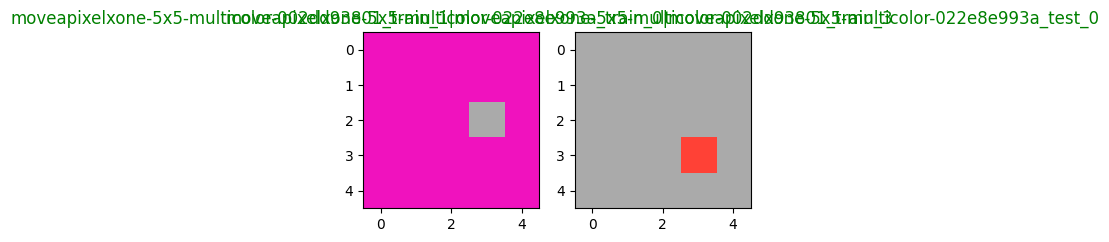

In [15]:
# Visualize any randome image along with the mask
def plot_one(ax, data, name, trim=False):
    grid = gsb_to_grid(data)
    tl_color = 'green' if np.all(grid == grid) else 'red'
    grid = trim_grid(grid) if trim else grid
    xx=grid_to_rgb(grid)
    ax.imshow(xx)
    ax.set_title(name, color=tl_color)

print("Grid Recovery")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3))
idx = 10 # next(i for i, s in enumerate(names) if s.startswith('moveapixelxone-5x5-f5c8a0d2f3'))
plot_one(ax1, data[idx][0][0], names[idx])

# print("Sanity Check:\nA rotated gsb should show '[ 0.96242838 -0.16512661  0.56377749]'")
print("Sanity Check:\nA rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'")
print(data[idx][0][0][0][0]) # idx, encoder. input, top, left.

idx = 10 # next(i for i, s in enumerate(test_names) if s.endswith('d4146d7159_test_1'))
plot_one(ax2, test_data[idx][1][0], test_names[idx])

## Start and End Tokens

In [16]:
def token_gen(pattern_str):
    ps = pattern_str.split('|')
    print(ps)
    ps_grid = np.array([ list(map(int, list(s))) for s in ps ])
    black = ps_grid == 0
    white = ps_grid == 1
    token_grid = black * 4 + white * 0 # Flip the code to black.
    return pad_grid(token_grid)

['11111', '10001', '10101', '10001', '11111']
['01110', '10101', '11011', '10101', '01110']


Text(0.5, 1.0, 'End')

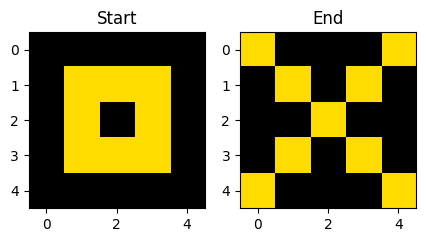

In [17]:
# QR code for "START_TASK" and "END_TASK"
# start_task_grid = token_gen(
# '111111100100001111111|100000100011101000001|101110100010001011101|101110100110001011101|\
# 101110100011101011101|100000101000001000001|111111101010101111111|000000000010000000000|\
# 100101101101110100000|011010011011010100000|111000110111001100101|111100001010101101000|\
# 110000101001011110101|000000001000000011010|111111100001111110110|100000101010000010011|\
# 101110100100111111110|101110101000010000011|101110100101010110001|100000100111100110000|111111101100000110110')
# end_task_grid   = token_gen(
# '111111100110001111111|100000101101001000001|101110100010001011101|101110100011001011101|\
# 101110101111101011101|100000100101001000001|111111101010101111111|000000000010000000000|\
# 101010100010100010010|111010000011011100110|101100101111010110011|011101010001110010000|\
# 011110110001001010111|000000001000001000010|111111100010100110111|100000100010001000010|\
# 101110101000101011100|101110100111010100110|101110101111011111001|100000100101110100010|111111101011011111111')
start_task_grid = token_gen('11111|10001|10101|10001|11111')
end_task_grid   = token_gen('01110|10101|11011|10101|01110')
STOP_TOKEN = grid_to_gsb(end_task_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 3))

ax1.imshow(grid_to_rgb(start_task_grid))
ax1.grid(False)
ax1.set_title("Start")

ax2.imshow(grid_to_rgb(end_task_grid))
ax2.grid(False)
ax2.set_title("End")

# Preprocessing

The Data Loaded: (Batch, Encoder/Decoder, Seq, X, Y, Channels)

## Data Parameters

In [18]:
# maxlen - max sequence length
encoder_maxlen = 2
decoder_maxlen = 2
GRID_SHAPE = (FG,FG,3)
zero_grid = np.zeros(GRID_SHAPE)
BUFFER_SIZE = 20000
BATCH_SIZE = 16

## Construct Training and Test Set

In [19]:
class ModelData():
    def __init__(self, data, names, attrs):
        self.data   = data
        self.names  = names
        self.attrs  = attrs
        self.enc_inp       = None
        self.enc_inp_model = None
        self.enc_seq_mask  = None
        self.dec_inp       = None
        self.dec_inp_model = None
        self.dec_seq_mask  = None
        self.dec_lbl       = None
        self.dec_lbl_model = None
        self.batches = None
        self._unpack()
        self._repackage()

    def _unpack(self):
        """
        The data's shape is (Batch, Encoder/Decoder, Seq, X, Y, Channels)
        This function split them up and reorganize them into a form more suitable for training and testing.
        . First it separates the Encoder / Decoder Sets as there are different entry points. (Batch, Seq, X, Y, Channels) x 2
        . It adds the STOP token to the decoder sequence.
        """
        print("Unpacking...")
        # np.split separates encoder from decoder => (Batch, 1, Seq, X, Y, Channels), (Batch, 1, Seq, X, Y, Channels)
        # np.squeeze removed the single dim => (Batch, Seq, X, Y, Channels), (Batch, Seq, X, Y, Channels)
        self.enc_inp, self.dec_inp = np.squeeze(np.split(self.data, len(self.data[0]), axis=1))

        ####
        # Encoder - the split output is the result.
        print("Encoder Input Shape: {}".format(self.enc_inp.shape))

        ####
        # Decoder
        # Splits the Sequence into it's constituents (Batch, X, Y, Channels)
        # seq = np.squeeze(np.split(self.dec_inp, len(self.dec_inp[0]), axis=1))
        # print([s.shape for s in seq])
        # Attach a STOP_TOKEN to the entire batch (Batch, X, Y, Channels)
        all_stop     = np.expand_dims(np.repeat([STOP_TOKEN], repeats=self.dec_inp.shape[0], axis=0), axis=1) # repeat for the entire batch.
        # Create Decoder Labels - Takes out the first token, append STOP.
        self.dec_lbl = np.append(self.dec_inp[:,1:], all_stop, axis=1)
        # Associate the same names since it is the same task.
        print("Decoder Input Shape: {}".format(self.dec_inp.shape))
        print("Decoder Label Shape: {}".format(self.dec_lbl.shape))

    def _repackage(self):
        print("Repackaging...")
        print("Encoder")
        self.enc_inp_model, self.enc_seq_mask = self._repack(self.enc_inp, encoder_maxlen)
        print("Decoder In")
        self.dec_inp_model, self.dec_seq_mask = self._repack(self.dec_inp, decoder_maxlen)
        print("Decoder Out")
        self.dec_lbl_model, _ = self._repack(self.dec_lbl, decoder_maxlen)
        print(self.enc_inp_model.shape, self.dec_inp_model.shape, self.dec_lbl_model.shape)

    def _repack(self, data_array, max_seq_length):
        """
        Create structures as required by the model feature length
        Padding/Truncating sequences for identical sequence lengths
        """
        print("Original\t", data_array.shape) # (Batch, Seq, X, Y, Channels)
        # print(data_array[0]) # Entry 0

        ######
        # Create the zero grid padded version (batch, max_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])
        # required as model feature length
        standardized = np.array([ np.concatenate((i, np.tile(zero_grid,(max(max_seq_length-len(i),0),1,1,1))), axis=0) for i in data_array ])
        print("Zero Padded\t", standardized.shape)

        ######
        # Mask: Create the 0 padded (batch, max_len) representaion of the data
        # This is to be used in create_masks.
        # Form [ [ 1's * Seq  ] * Batch ], i.e. for data (10, 2, 5, 5, 3),
        # forms [ [ 1, 1 ] * 10 ] where the inner list is an np.array
        seq_mask = [ np.ones((len(i)), dtype=np.int32) for i in data_array ]
        # Then pad with 0 as a mask to fill the length to max_seq_length,
        # required as model feature length
        seq_mask = tf.keras.preprocessing.sequence.pad_sequences(seq_mask, maxlen=max_seq_length, padding='post', truncating='post')
        print("Sequence Mask\t", seq_mask.shape,seq_mask[0])

        return standardized, seq_mask

    def prepare_batch(self, enc, dec, lbl):
        print(enc)
        print(dec)
        enc_batch = tf.convert_to_tensor(enc)  # Convert to 0-padded dense Tensor

        dec_batch  = tf.convert_to_tensor(dec)  # Drop the [END] token - decoder input
        dec_labels = tf.convert_to_tensor(lbl)  # Drop the First token - decoder output

        return (enc_batch, dec_batch), dec_labels

    def make_batches(self, ds):
        return (
          ds
          .shuffle(ds.cardinality())
          .batch(BATCH_SIZE)
          .map(self.prepare_batch, tf.data.AUTOTUNE)
          .prefetch(buffer_size=tf.data.AUTOTUNE))

    def shuffle_and_batch(self):
        print("Shuffling... use ModelData.batches to retrieve")
        ds = tf.data.Dataset.from_tensor_slices((self.enc_inp_model, self.dec_inp_model, self.dec_lbl_model))
        self.batches = self.make_batches(ds)
        print(self.batches)

    def plot_task(self, task_id):
        fig, axes = plt.subplots(2, 3, figsize = (7, 7))
        print(self.names[task_id])
        plot_one(axes[0,0], self.enc_inp[task_id][0], self.names[task_id], trim=False)
        plot_one(axes[0,1], self.enc_inp[task_id][1], "", trim=False)
        axes[0,2].axis('off')
        plot_one(axes[1,0], self.dec_inp[task_id][0], self.names[task_id], trim=False)
        plot_one(axes[1,1], self.dec_inp[task_id][1], "", trim=False)
        plot_one(axes[1,2], STOP_TOKEN, "", trim=False)

In [20]:
training_set = ModelData(data, names, attrs)
validatn_set = ModelData(test_data, test_names, test_attrs)

Unpacking...
Encoder Input Shape: (19196, 2, 5, 5, 3)
Decoder Input Shape: (19196, 2, 5, 5, 3)
Decoder Label Shape: (19196, 2, 5, 5, 3)
Repackaging...
Encoder
Original	 (19196, 2, 5, 5, 3)
Zero Padded	 (19196, 2, 5, 5, 3)
Sequence Mask	 (19196, 2) [1 1]
Decoder In
Original	 (19196, 2, 5, 5, 3)
Zero Padded	 (19196, 2, 5, 5, 3)
Sequence Mask	 (19196, 2) [1 1]
Decoder Out
Original	 (19196, 2, 5, 5, 3)
Zero Padded	 (19196, 2, 5, 5, 3)
Sequence Mask	 (19196, 2) [1 1]
(19196, 2, 5, 5, 3) (19196, 2, 5, 5, 3) (19196, 2, 5, 5, 3)
Unpacking...
Encoder Input Shape: (4190, 2, 5, 5, 3)
Decoder Input Shape: (4190, 2, 5, 5, 3)
Decoder Label Shape: (4190, 2, 5, 5, 3)
Repackaging...
Encoder
Original	 (4190, 2, 5, 5, 3)
Zero Padded	 (4190, 2, 5, 5, 3)
Sequence Mask	 (4190, 2) [1 1]
Decoder In
Original	 (4190, 2, 5, 5, 3)
Zero Padded	 (4190, 2, 5, 5, 3)
Sequence Mask	 (4190, 2) [1 1]
Decoder Out
Original	 (4190, 2, 5, 5, 3)
Zero Padded	 (4190, 2, 5, 5, 3)
Sequence Mask	 (4190, 2) [1 1]
(4190, 2, 5, 5, 3)

In [21]:
training_set.shuffle_and_batch()
validatn_set.shuffle_and_batch()

Shuffling... use ModelData.batches to retrieve
Tensor("args_0:0", shape=(None, 2, 5, 5, 3), dtype=float64)
Tensor("args_1:0", shape=(None, 2, 5, 5, 3), dtype=float64)
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>
Shuffling... use ModelData.batches to retrieve
Tensor("args_0:0", shape=(None, 2, 5, 5, 3), dtype=float64)
Tensor("args_1:0", shape=(None, 2, 5, 5, 3), dtype=float64)
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>


In [22]:
print(training_set.batches)
print(validatn_set.batches)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2, 5, 5, 3), dtype=tf.float64, name=None))>


moveapixelxone-5x5-multicolor-034514d1fb_train_1|moveapixelxone-5x5-multicolor-034514d1fb_train_2


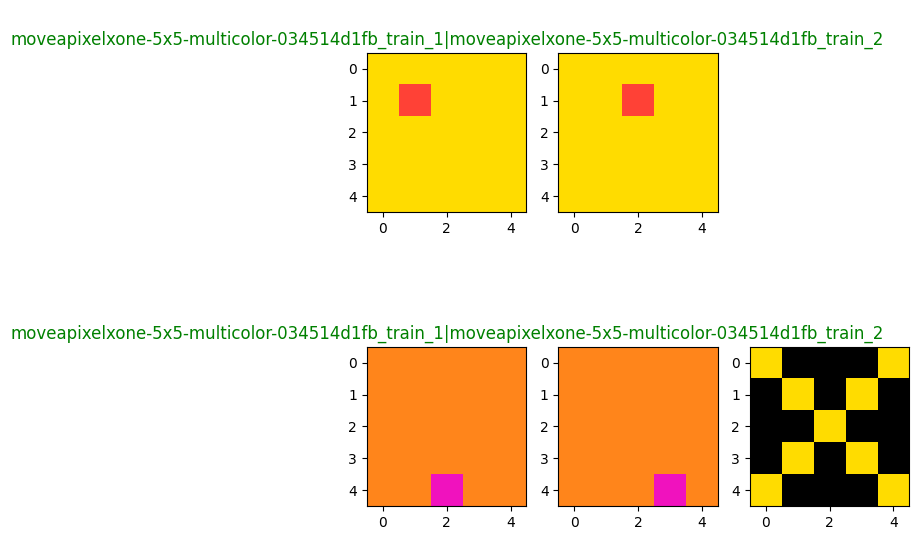

In [23]:
# Take a look at a random task.
task_id = 100
training_set.plot_task(task_id)

# Building the Model

## Embedding Layer (Adapted)

In [24]:
class EmbeddingLayer(tf.keras.layers.Layer):
    # say seq_len = 4,
    # Then each should go through the same embedding weights,
    # yield dimention d_model
    #
    # So:
    # Input  (batch_size, seq_len, FG, FG, 3)
    # Output (batch_size, seq_len, d_model)
    #
    def __init__(self, in_shape, d_model):
        super(EmbeddingLayer, self).__init__()

        self.raw  = tf.keras.Input(in_shape,name="raw")
        self.flat = tf.keras.layers.Flatten(name="raw_flatten")(self.raw)
        print("EmbeddingLayer")
        print("Raw Flatten", self.flat.shape)

        # CNN Layer(s)
        # print(self.raw)
        self.cnn1 = tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),strides=(1,1),padding="same", name="cnn1")(self.raw) # activation?
        print("CNN 1", self.cnn1.shape)
        self.cnn1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='valid')(self.cnn1)
        print("MaxPooled", self.cnn1.shape)
        self.cnn1 = tf.keras.layers.Flatten(name="cnn1_flatten")(self.cnn1)
        print("CNNLayer", self.cnn1.shape)

        # Concat
        self.merged = tf.keras.layers.concatenate([self.flat, self.cnn1], axis=-1)
        self.merged = tf.keras.layers.Dense(d_model, activation='relu', kernel_initializer="he_normal", name="dense")(self.merged)
        # self.merged = tf.keras.layers.Dense(d_model, activation='relu', kernel_initializer="he_normal", name="dense")(self.flat)
        print("Merged", self.merged.shape)

        self.encoder = tf.keras.Model(inputs=[self.raw],outputs=[self.merged], name = "cnn")

    def call(self, x, training):
        # Apply the same encoder to each element in the sequence
        seq = tf.unstack(x, axis=1)
        emb = [ self.encoder( s ) for s in seq ]
        output = tf.stack(emb, axis=1)

        return output

## Positional Encoding (Adapted)

In [25]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [26]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, length, embedding_layer, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = embedding_layer
    self.pos_encoding = positional_encoding(length=length, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

## Base Attention Layer

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## Cross Attention Layer

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

## Global Self-Attention Layer

In [29]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Causal Self-Attention Layer

In [30]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Feed Forward Network

In [31]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

## Encoder Layer

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

## Encoder (Adapted)

In [33]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               pos_enc_len, embedding_layer,
               dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        length=pos_enc_len, embedding_layer=embedding_layer, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


## Decoder Layer

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x


## Decoder (Adapted)

In [35]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               pos_enc_len, embedding_layer,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(length=pos_enc_len,
                                             embedding_layer=embedding_layer,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

## The Transformer (Adapted)

In [36]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               enc_len, dec_len, embedding_layer, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           pos_enc_len=enc_len,
                           embedding_layer=embedding_layer,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers*2, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           pos_enc_len=dec_len,
                           embedding_layer=embedding_layer,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.models.Sequential()
    self.final_layer.add( tf.keras.layers.Dense(np.prod(GRID_SHAPE)) )
    self.final_layer.add( tf.keras.layers.Reshape((-1,GRID_SHAPE[0],GRID_SHAPE[1],GRID_SHAPE[2])) ) # <- what's the right param?

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, target = inputs # enc, dec

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(target, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    final_output = self.final_layer(x)  # (batch_size, target_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del final_output._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return final_output



# Training Set Up

## Hyperparameters

In [37]:
# hyper-params
num_layers = 1
d_model = 128
dff = 512
num_heads = 1 # 8
EPOCHS = 60
dropout = 0.1
lr = 1e-03
lr_patience = 8
lr_factor = 0.8

## Transformer

In [38]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    enc_len=encoder_maxlen,
    dec_len=decoder_maxlen,
    embedding_layer=EmbeddingLayer( in_shape=GRID_SHAPE, d_model=d_model),
    dropout_rate=dropout)

EmbeddingLayer
Raw Flatten (None, 75)
CNN 1 (None, 5, 5, 1)
MaxPooled (None, 3, 3, 1)
CNNLayer (None, 9)
Merged (None, 128)


In [39]:
# Test it:
output = transformer((training_set.enc_inp_model, training_set.dec_inp_model))

In [40]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(19196, 1, 2, 2)


In [41]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  209180    
                                                                 
 decoder (Decoder)           multiple                  540060    
                                                                 
 sequential_3 (Sequential)   (19196, 2, 5, 5, 3)       9675      
                                                                 
Total params: 748007 (2.85 MB)
Trainable params: 748007 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Set up the optimizer

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=8000): # ~ 128000 / batch_size
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    # k = tf.cast(0.125, dtype=tf.float32) * tf.cast(tf.math.greater( step, self.warmup_steps), tf.float32) + (
    #     tf.cast(1.   , dtype=tf.float32) * tf.cast(tf.math.less_equal( step, self.warmup_steps), tf.float32))
    arg1 = tf.math.rsqrt(step) # * tf.math.exp(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
# learning_rate = learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#   initial_learning_rate=0.001,
#   decay_steps=40000,
#   decay_rate=0.6)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

## Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

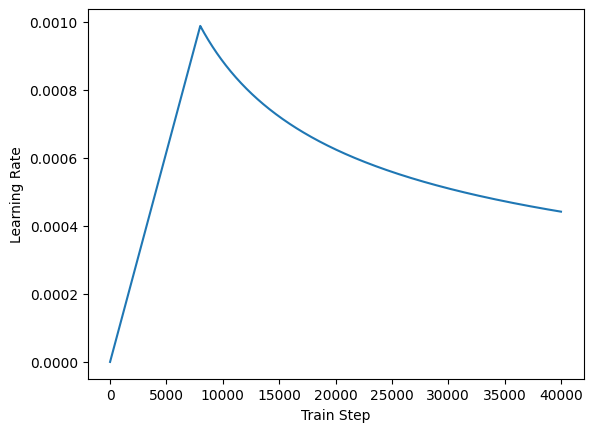

In [49]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
# plt.ylim(0,0.001)

## Adapt the loss and metrics

In [50]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.MeanSquaredError() # MSE is better with the same EPOCHs. tf.keras.losses.Huber(delta=0.02) # tf.keras.losses.MeanAbsoluteError()
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
      return optimizer.lr # I use ._decayed_lr method instead of .lr
  return lr

In [51]:
from collections import defaultdict

def merge_dict(dict_list):
  dd = defaultdict(list)
  for d in dict_list:
      print(d)
      for key, value in d.items():
          if not hasattr(value, '__iter__'):
              # value = (value,)
              dd[key].append(value)
          else:
              dd[key].extend(value)
  return dict(dd)

def update_history(history, latest):
  if not history or len(history.params)==0:
      history = latest
  else:
      history.history = merge_dict([ history.history, latest.history ])
  return history

# Training

In [52]:
transformer.compile(
   loss=masked_loss,
   optimizer=optimizer,
   metrics=[ get_lr_metric(optimizer)] # [masked_accuracy] # tf.keras.metrics.Accuracy(),
)

In [53]:
full_history={}

In [54]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

In [55]:
to_restore=False

if to_restore and ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [56]:
run_history = transformer.fit(
      training_set.batches,
      epochs=EPOCHS,
      validation_data=validatn_set.batches)

Epoch 1/60
1200/1200 [==============================] - 46s 25ms/step - loss: 0.3533 - lr: 7.4054e-05 - val_loss: 0.1374 - val_lr: 1.4811e-04
Epoch 2/60
1200/1200 [==============================] - 30s 24ms/step - loss: 0.0972 - lr: 2.2229e-04 - val_loss: 0.0355 - val_lr: 2.9634e-04
Epoch 3/60
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0335 - lr: 3.7052e-04 - val_loss: 0.0164 - val_lr: 4.4457e-04
Epoch 4/60
1200/1200 [==============================] - 29s 24ms/step - loss: 0.0193 - lr: 5.1875e-04 - val_loss: 0.0129 - val_lr: 5.9280e-04
Epoch 5/60
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0162 - lr: 6.6698e-04 - val_loss: 0.0126 - val_lr: 7.4103e-04
Epoch 6/60
1200/1200 [==============================] - 28s 24ms/step - loss: 0.0144 - lr: 8.1521e-04 - val_loss: 0.0125 - val_lr: 8.8927e-04
Epoch 7/60
1200/1200 [==============================] - 29s 24ms/step - loss: 0.0138 - lr: 9.5122e-04 - val_loss: 0.0122 - val_lr: 9.6445e-04
Epoch 

In [57]:
full_history = update_history( full_history, run_history)

## Save Checkpoint Manually

In [58]:
ckpt_save_path = ckpt_manager.save()

# Stats

## Learning Curve

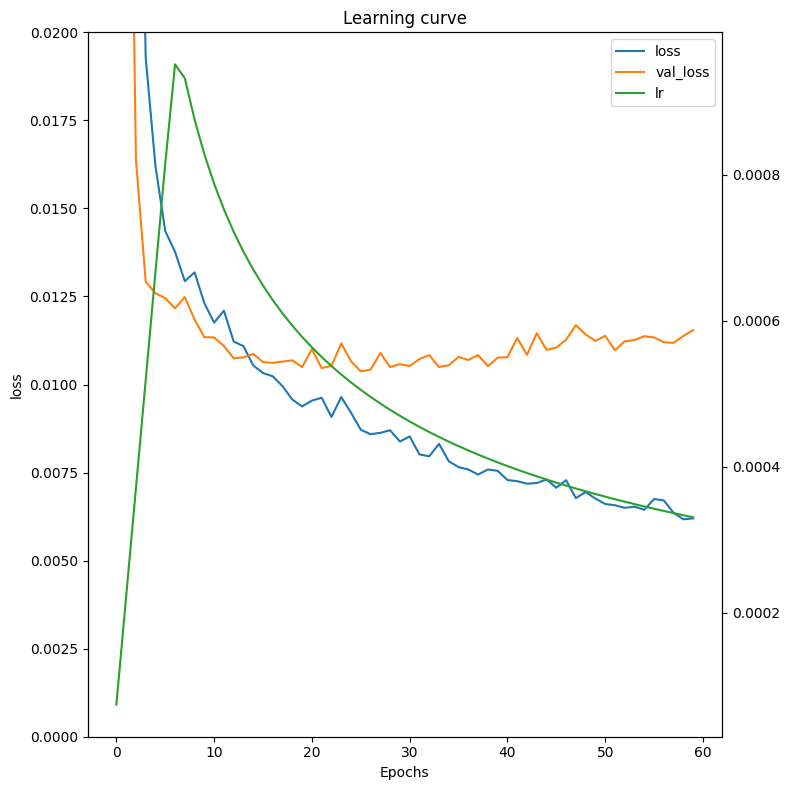

In [59]:
fig, ax1 = plt.subplots(figsize=(8, 8))
plt.title("Learning curve")

ln1 = ax1.plot(full_history.history['loss'], label="loss")
ln2 = ax1.plot(full_history.history['val_loss'], label = "val_loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("loss")
ax1.set_ylim(0, 0.02)
# ax1.set_xlim(100, 180)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ln3 = ax2.plot(full_history.history['lr'], label = "lr", color=color)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# transformer.summary()

## Survey Model Weights

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  209180    
                                                                 
 decoder (Decoder)           multiple                  540060    
                                                                 
 sequential_3 (Sequential)   (None, 2, 5, 5, 3)        9675      
                                                                 
Total params: 748007 (2.85 MB)
Trainable params: 748007 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


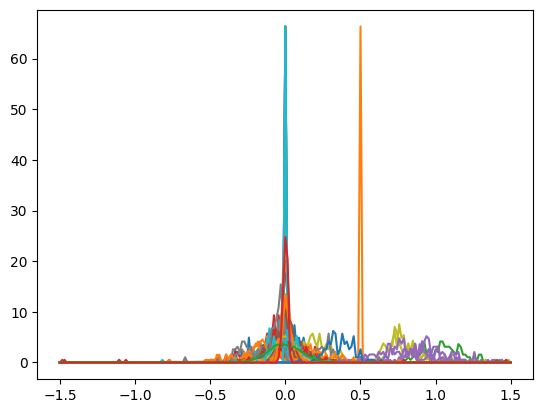

In [60]:
transformer.summary()
# weights = transformer.get_weights()
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-1.5, 1.5, 200), density=True)
    plt.plot(np.linspace(-1.5, 1.5, len(pr)), pr) # , label='real', color='g', linewidth=2)

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


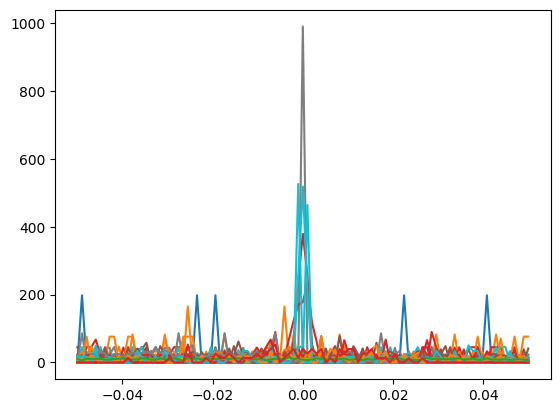

In [61]:
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-0.05, 0.05, 100), density=True)
    plt.plot(np.linspace(-0.05, 0.05, len(pr)), pr) # , label='real', color='g', linewidth=2)
# plt.clf()

# Inference

In [62]:
loss_function=tf.keras.losses.MeanSquaredError()

In [63]:
# Predicting one token at a time at the decoder and appending it to the output;
# then taking the complete sequence as an input to the decoder,
# repeating until maxlen or stop keyword appears
def predict(model, encoder_input, decoder_input):

    stop_detected = False

    # maxlen = decoder_maxlen # tar_len if tar_len else decoder_maxlen
    for i in range(decoder_maxlen):
        predictions = model( (encoder_input, decoder_input) )
        latest = np.array(predictions[-1,-1])
        if not stop_detected:
            stop_detected = np.all(np.equal(gsb_to_grid(latest), end_task_grid))
        latest_append = np.array(np.expand_dims(latest, axis=(0,1)))
        decoder_input = np.concatenate([decoder_input, latest_append], axis=1)

    return tf.squeeze(decoder_input, axis=0), stop_detected # attention_weights


## Solving and Plotting Utilities

In [64]:
def solve_one(model, inp, tar):
    inp_ = np.expand_dims(inp, axis=0)
    tar_ = np.expand_dims(tar[0], axis=(0,1))
    pred, stop_detected = predict(model, inp_, tar_)
    print(pred.shape, tar.shape)
    loss = loss_function(tar, pred[:-1])
    return pred, loss, stop_detected

In [65]:
def is_exact_match(target, prediction):
    tar_grid = np.array(list(map(gsb_to_grid, target)))
    pred_grid= np.array(list(map(gsb_to_grid, prediction.numpy())))
    return np.all(np.equal(tar_grid,pred_grid))

In [66]:
# Plot task grids
def plot_task( inp, tar, pred, idx ):
    fig, axes = plt.subplots(1, len(inp[idx]), figsize = (3, 9))
    for i in range(len(inp[idx])):
        plot_one(axes[i], np.array(inp[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(tar[idx])+1, figsize = (6, 9))
    for i in range(len(tar[idx])):
        plot_one(axes[i], np.array(tar[idx][i]), "", trim=False)
    plot_one(axes[i+1], STOP_TOKEN, "", trim=False)
    fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))
    for i in range(len(pred)):
        plot_one(axes[i], np.array(pred[i]), "", trim=False)

In [67]:
def solve_and_plot(model, from_dataset, idxs=None):

    inp_names    = from_dataset.names
    target_names = from_dataset.names
    inp           = from_dataset.enc_inp_model
    tar           = from_dataset.dec_inp_model

    if not idxs:
        # Pick a random one
        idxs = [np.random.randint(0, len(inp))]

    count=0
    for idx in idxs:
        print("Task index: {}, Input: {}, Target: {}".format(idx, inp_names[idx], target_names[idx]))
        # Run prediction
        pred, loss, stop_detected = solve_one(model, inp[idx], tar[idx])
        accurate = is_exact_match(tar[idx], pred[:-1])
        print("Result Elements: {}, Accurate: {}, Shape: {}, Stopped: {}".format(len(pred), accurate, pred.shape, stop_detected))
        print("Loss", loss)
        plot_task( inp, tar, pred, idx )
        count+=1
        if count == 10: break

## Score Test Set

In [68]:
val_loss   = tf.keras.metrics.Mean(name='val_loss')

def _gsb_to_grid(gsb_grid):
    """
    Recover the integer-based color index Grid.
    """
    # Get the input GSB grid into a form to be compared to 11 fixed points
    g = gsb_grid.copy()
    g = np.expand_dims(g, 4)
    g = np.repeat(g, 11, axis=4)
    # Build the fixed points to match the dimensions of the input.
    mask = np.tile(solid,gsb_grid.shape[:-1]+(1,1))
    # Do the subtraction and l2 norm
    dist = np.linalg.norm(g - mask, axis=5)
    # np.argmin provides the index (out of 11) that has the smallest distance
    recovered = np.argmin(dist, axis=4)

    return recovered

def cal_accuracy(label, pred):
  print(label.shape, pred.shape)
  # To color index grid
  label_grid = _gsb_to_grid(label)
  pred_grid  = _gsb_to_grid(pred)
  # Subtract
  diff = pred_grid - label_grid
  # Matches are all 0s for axes SEQ,FG,FG
  is_diff = abs(diff)>0.0
  is_diff = np.max(is_diff,axis=(1,2,3))
  match = np.where(is_diff==0)[0]

  return len(match), match

def test_stops(pred):
  # Test for STOP_TOKENS
  pred_grid  = _gsb_to_grid(pred)
  # Compare the last in SEQ to the Stop Token
  diff = pred_grid[:,-1] - end_task_grid
  # Matches are all 0s for axes FG,FG
  is_diff = abs(diff)>0.0
  is_diff = np.max(is_diff,axis=(1,2))
  stops = np.where(is_diff==0)[0]
  return len(stops)

def score(model, data_set):

  val_loss.reset_states()
  accurate=[]

  inp           = data_set.enc_inp
  tar           = np.expand_dims(data_set.dec_inp[:,0], axis=1)

  for i in range(decoder_maxlen):
    pred = model( (inp, tar) )
    print(pred.shape)
    latest = pred[:,-1]
    tar = np.concatenate([tar, np.expand_dims(latest, axis=1)], axis=1)

  loss = loss_function(data_set.dec_inp, tar[:, :-1])
  accuracy, idxs = cal_accuracy(data_set.dec_inp, tar[:, :-1])
  stops = test_stops(tar)

  print("Count: {}, Avg loss: {:.4f}, Accuracy: {} ({:.4f}), Stops found: {}".format(len(inp), loss, accuracy, accuracy/len(inp), stops))

  return idxs.tolist() # accurate

In [69]:
correct_idxs = score(transformer, validatn_set)
print(correct_idxs)

(4190, 1, 5, 5, 3)
(4190, 2, 5, 5, 3)
(4190, 2, 5, 5, 3) (4190, 2, 5, 5, 3)
Count: 4190, Avg loss: 0.0115, Accuracy: 112 (0.0267), Stops found: 4190
[62, 132, 133, 172, 181, 203, 205, 234, 243, 264, 284, 363, 435, 444, 605, 614, 615, 635, 671, 687, 814, 828, 901, 935, 936, 959, 1000, 1132, 1159, 1298, 1304, 1317, 1348, 1398, 1532, 1551, 1574, 1581, 1588, 1603, 1782, 1786, 1814, 1816, 1826, 1843, 1881, 1983, 2018, 2260, 2322, 2381, 2394, 2405, 2426, 2453, 2561, 2606, 2641, 2681, 2692, 2738, 2754, 2795, 2798, 2898, 2962, 3039, 3061, 3088, 3090, 3102, 3119, 3143, 3144, 3154, 3177, 3222, 3260, 3268, 3283, 3351, 3373, 3389, 3435, 3481, 3557, 3581, 3586, 3637, 3664, 3671, 3694, 3705, 3747, 3755, 3767, 3826, 3865, 3909, 3930, 3931, 3985, 3989, 4011, 4055, 4064, 4086, 4103, 4116, 4156, 4176]


Task index: 62, Input: moveapixelxone-5x5-multicolor-0c54007401_train_0|moveapixelxone-5x5-multicolor-0c54007401_test_0, Target: moveapixelxone-5x5-multicolor-0c54007401_train_0|moveapixelxone-5x5-multicolor-0c54007401_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.001752295112212866, shape=(), dtype=float64)
Task index: 132, Input: moveapixelxone-5x5-multicolor-1ceca064ce_train_0|moveapixelxone-5x5-multicolor-1ceca064ce_test_0, Target: moveapixelxone-5x5-multicolor-1ceca064ce_train_0|moveapixelxone-5x5-multicolor-1ceca064ce_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0036308841548139507, shape=(), dtype=float64)
Task index: 133, Input: moveapixelxone-5x5-multicolor-1d23dcefd9_train_0|moveapixelxone-5x5-multicolor-1d23dcefd9_test_0, Target: moveapixelxone-5x5-multicolor-1d23dcefd9_train_0|moveapixelxone-5x5-multicolor-1d23dcefd9_test_0
(

<ipython-input-66-b6384dd7e73c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


Task index: 234, Input: moveapixelxone-5x5-multicolor-352275878c_train_0|moveapixelxone-5x5-multicolor-352275878c_test_0, Target: moveapixelxone-5x5-multicolor-352275878c_train_0|moveapixelxone-5x5-multicolor-352275878c_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.002056358238041628, shape=(), dtype=float64)
Task index: 243, Input: moveapixelxone-5x5-multicolor-37355da320_train_0|moveapixelxone-5x5-multicolor-37355da320_test_0, Target: moveapixelxone-5x5-multicolor-37355da320_train_0|moveapixelxone-5x5-multicolor-37355da320_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0014870474884187892, shape=(), dtype=float64)
Task index: 264, Input: moveapixelxone-5x5-multicolor-3da460bd02_train_0|moveapixelxone-5x5-multicolor-3da460bd02_test_0, Target: moveapixelxone-5x5-multicolor-3da460bd02_train_0|moveapixelxone-5x5-multicolor-3da460bd02_test_0


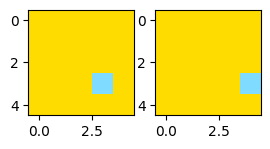

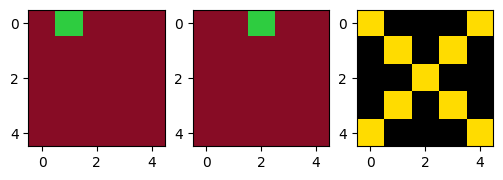

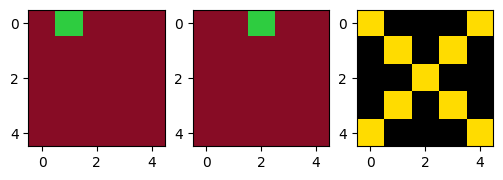

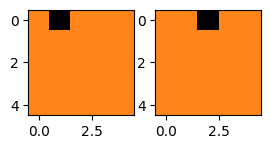

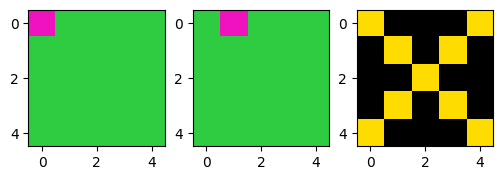

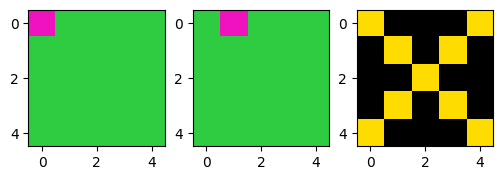

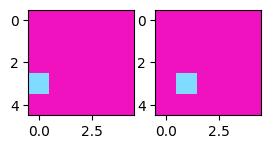

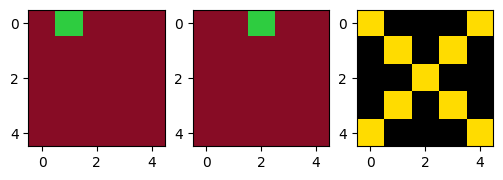

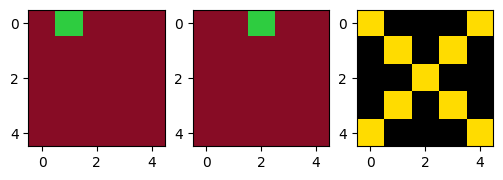

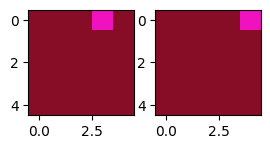

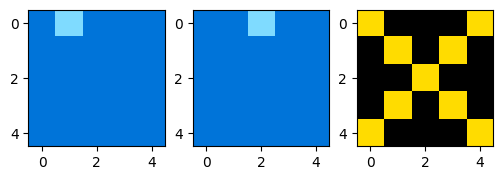

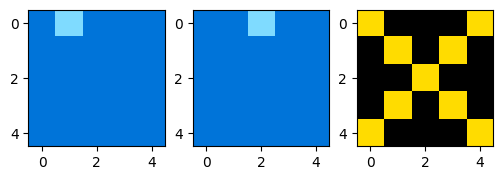

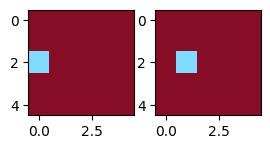

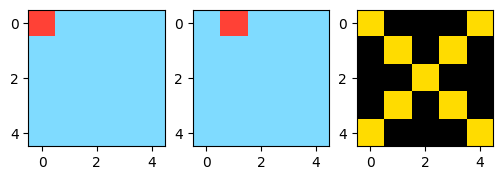

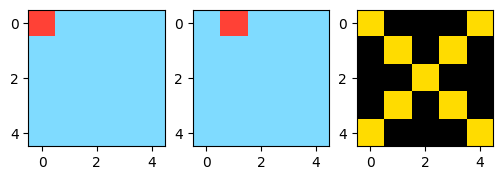

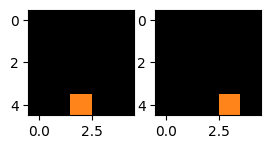

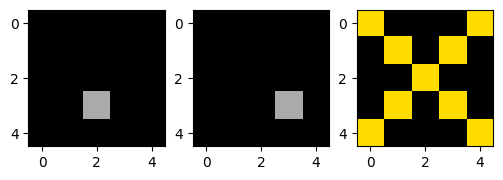

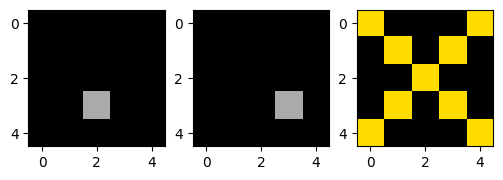

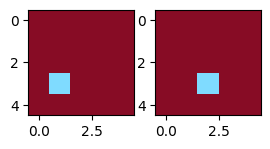

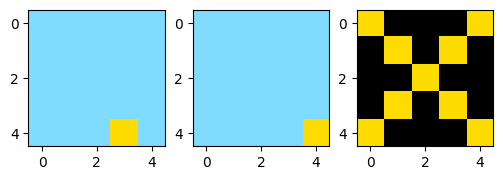

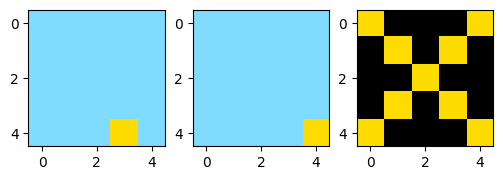

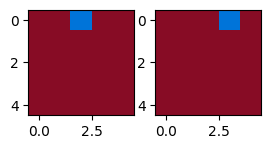

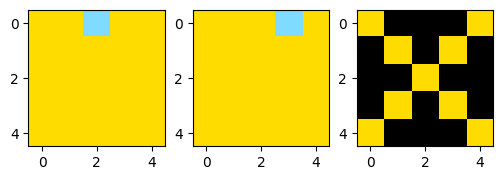

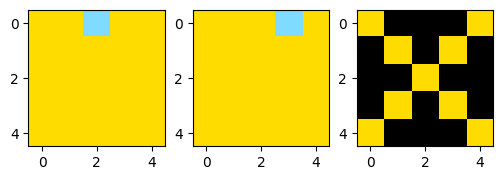

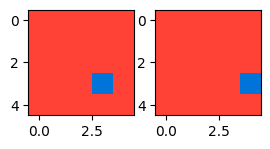

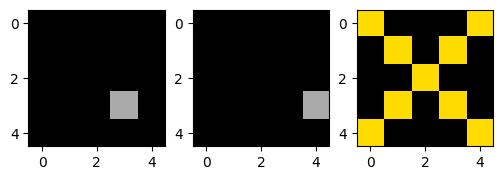

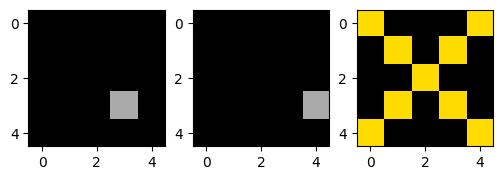

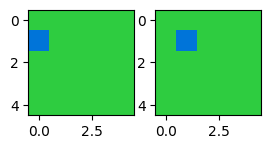

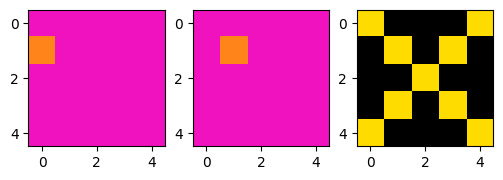

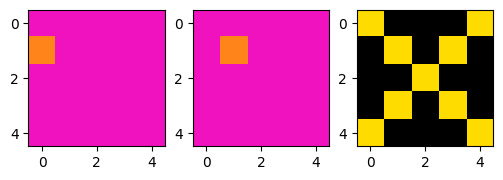

In [70]:
solve_and_plot(transformer, validatn_set, correct_idxs)

## Random Pick from Test Set

Task index: 3898, Input: moveapixelxone-5x5-multicolor-d-b74f729876_train_0|moveapixelxone-5x5-multicolor-d-b74f729876_test_0, Target: moveapixelxone-5x5-multicolor-d-b74f729876_train_0|moveapixelxone-5x5-multicolor-d-b74f729876_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.006229876822695062, shape=(), dtype=float64)


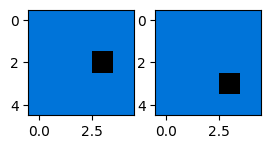

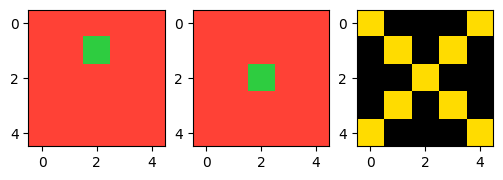

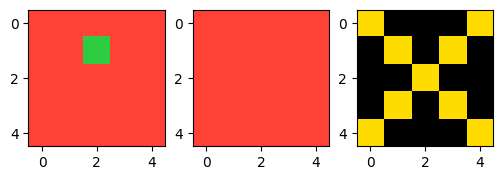

In [76]:
solve_and_plot(transformer, validatn_set)

## Score Train Set

In [77]:
correct_idxs = score(transformer, training_set)
print(correct_idxs)

(19196, 1, 5, 5, 3)
(19196, 2, 5, 5, 3)
(19196, 2, 5, 5, 3) (19196, 2, 5, 5, 3)
Count: 19196, Avg loss: 0.0047, Accuracy: 7562 (0.3939), Stops found: 19196
[0, 2, 4, 8, 12, 16, 17, 20, 21, 28, 29, 33, 36, 37, 40, 41, 45, 49, 50, 53, 54, 55, 57, 58, 61, 62, 65, 66, 67, 68, 69, 76, 78, 81, 82, 87, 90, 92, 98, 102, 106, 109, 110, 111, 113, 114, 117, 118, 124, 125, 126, 130, 134, 135, 138, 140, 141, 142, 145, 146, 149, 150, 153, 154, 157, 158, 161, 170, 171, 174, 178, 179, 183, 185, 186, 187, 192, 195, 207, 209, 210, 211, 214, 215, 216, 219, 220, 221, 222, 223, 226, 227, 237, 246, 250, 251, 253, 254, 255, 259, 263, 264, 265, 266, 267, 268, 270, 271, 274, 275, 276, 278, 279, 282, 283, 287, 288, 291, 292, 294, 295, 299, 304, 307, 311, 315, 316, 320, 324, 327, 328, 329, 331, 332, 333, 335, 338, 339, 340, 348, 351, 352, 356, 363, 367, 368, 373, 375, 383, 387, 388, 389, 391, 392, 393, 395, 396, 400, 409, 410, 412, 413, 417, 421, 422, 424, 425, 429, 430, 433, 434, 438, 442, 446, 449, 450, 456, 4

## Plot Correct Train Tasks

7562
[7332, 6746, 4572, 8875, 1120, 9206, 2012, 10335, 18086, 14556]
Task index: 7332, Input: moveapixelxone-5x5-multicolor-l-814f4183e4_train_3|moveapixelxone-5x5-multicolor-l-814f4183e4_train_2, Target: moveapixelxone-5x5-multicolor-l-814f4183e4_train_3|moveapixelxone-5x5-multicolor-l-814f4183e4_train_2
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0005449407690288818, shape=(), dtype=float64)
Task index: 6746, Input: moveapixelxone-5x5-multicolor-l-6753e9b144_train_1|moveapixelxone-5x5-multicolor-l-6753e9b144_train_2, Target: moveapixelxone-5x5-multicolor-l-6753e9b144_train_1|moveapixelxone-5x5-multicolor-l-6753e9b144_train_2
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00298207407127619, shape=(), dtype=float64)
Task index: 4572, Input: moveapixelxone-5x5-multicolor-f6a201e00a_train_1|moveapixelxone-5x5-multicolor-f6a201e00a_train_1, Target: movea

<ipython-input-66-b6384dd7e73c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.001196175413000756, shape=(), dtype=float64)
Task index: 18086, Input: moveapixelxone-5x5-multicolor-d-c429080488_train_1|moveapixelxone-5x5-multicolor-d-c429080488_train_2, Target: moveapixelxone-5x5-multicolor-d-c429080488_train_1|moveapixelxone-5x5-multicolor-d-c429080488_train_2
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.002370943606158282, shape=(), dtype=float64)
Task index: 14556, Input: moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_1|moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_1, Target: moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_1|moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_1
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0017551669371557417, shape=(), dtype=float64)


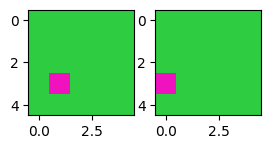

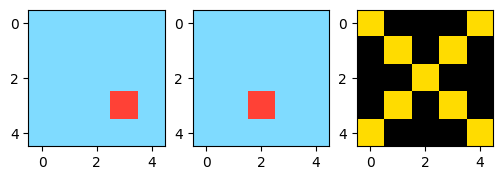

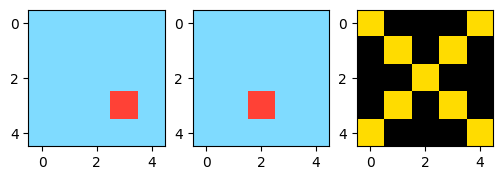

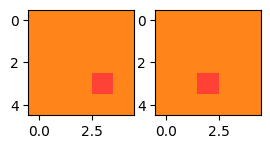

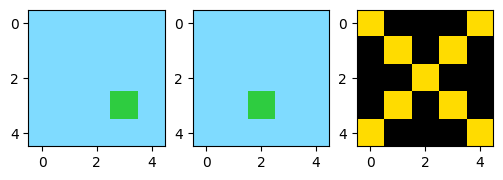

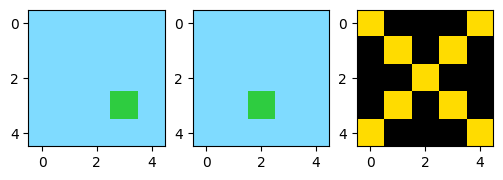

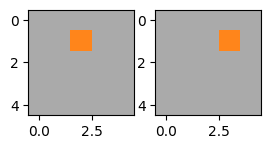

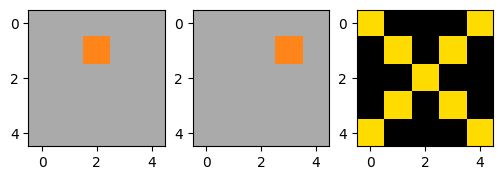

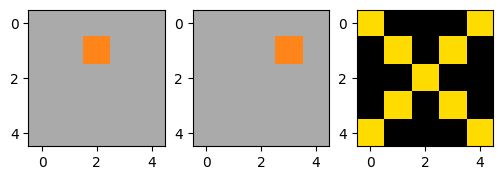

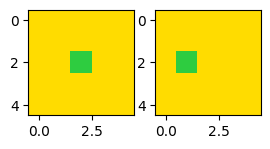

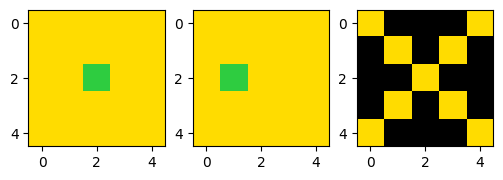

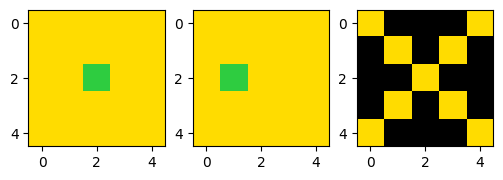

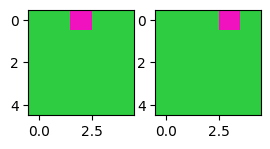

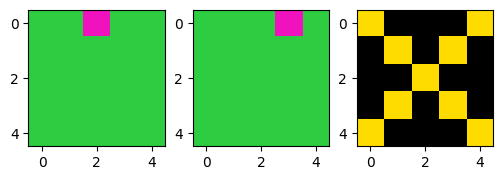

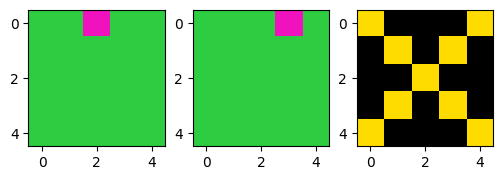

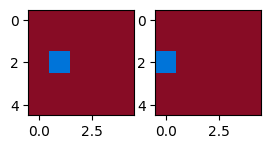

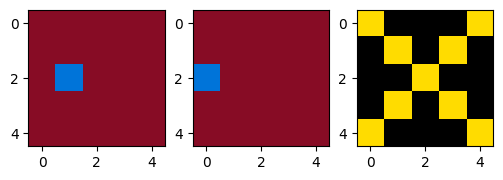

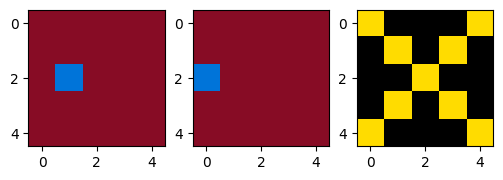

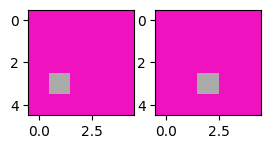

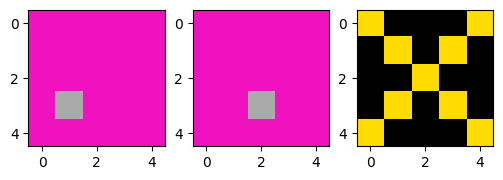

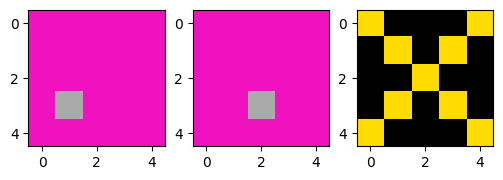

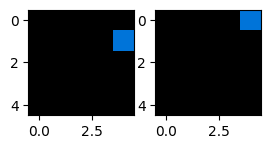

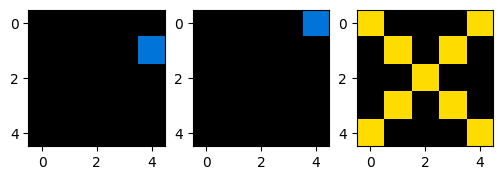

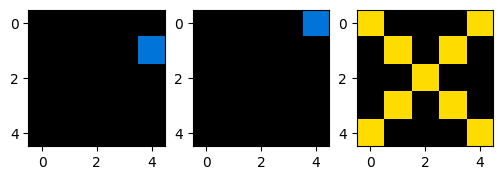

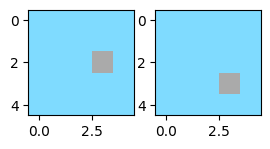

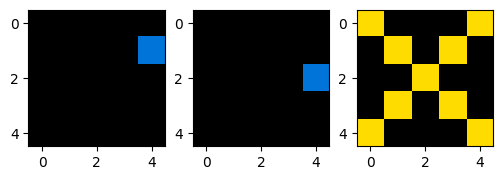

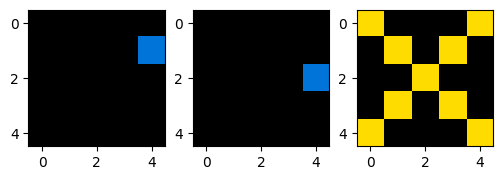

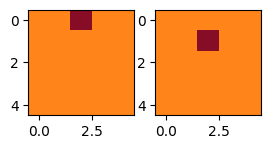

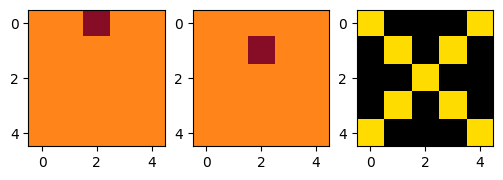

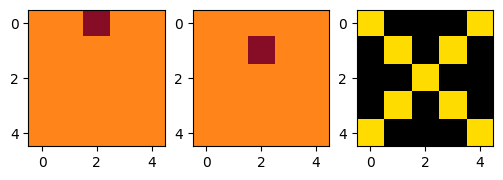

In [78]:
print (len(correct_idxs))
if len(correct_idxs) > 0:
  subset=[ correct_idxs[np.random.randint(0, len(correct_idxs))] for i in range(10) ]
  print(subset)
  solve_and_plot(transformer, training_set, subset)

## Plot Corresponding Test Tasks
These are the same training tasks with correct prediction in the Training set, but now we find those same tasks in the Test set.

In [79]:
crt = {}
for c in subset:
  task = training_set.names[c].split("_")[0]
  if task in crt:
    crt[task]+=1
  else:
    crt[task]=0
print(len(crt)) # 24 / 400 - 6%
print(crt)

10
{'moveapixelxone-5x5-multicolor-l-814f4183e4': 0, 'moveapixelxone-5x5-multicolor-l-6753e9b144': 0, 'moveapixelxone-5x5-multicolor-f6a201e00a': 0, 'moveapixelxone-5x5-multicolor-l-d6238ddd00': 0, 'moveapixelxone-5x5-multicolor-3cccd74401': 0, 'moveapixelxone-5x5-multicolor-l-e8039ef6de': 0, 'moveapixelxone-5x5-multicolor-6a18f88787': 0, 'moveapixelxone-5x5-multicolor-u-2e1f42a537': 0, 'moveapixelxone-5x5-multicolor-d-c429080488': 0, 'moveapixelxone-5x5-multicolor-d-0bbd8fbbb7': 0}


Task index: 1612, Input: moveapixelxone-5x5-multicolor-l-814f4183e4_train_0|moveapixelxone-5x5-multicolor-l-814f4183e4_test_0, Target: moveapixelxone-5x5-multicolor-l-814f4183e4_train_0|moveapixelxone-5x5-multicolor-l-814f4183e4_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.006004527635279155, shape=(), dtype=float64)
Task index: 1484, Input: moveapixelxone-5x5-multicolor-l-6753e9b144_train_0|moveapixelxone-5x5-multicolor-l-6753e9b144_test_0, Target: moveapixelxone-5x5-multicolor-l-6753e9b144_train_0|moveapixelxone-5x5-multicolor-l-6753e9b144_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.014320523169097179, shape=(), dtype=float64)
Task index: 1018, Input: moveapixelxone-5x5-multicolor-f6a201e00a_train_0|moveapixelxone-5x5-multicolor-f6a201e00a_test_0, Target: moveapixelxone-5x5-multicolor-f6a201e00a_train_0|moveapixelxone-5x5-multicolo

<ipython-input-66-b6384dd7e73c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.015218587478752266, shape=(), dtype=float64)
Task index: 3955, Input: moveapixelxone-5x5-multicolor-d-c429080488_train_0|moveapixelxone-5x5-multicolor-d-c429080488_test_0, Target: moveapixelxone-5x5-multicolor-d-c429080488_train_0|moveapixelxone-5x5-multicolor-d-c429080488_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.005496077975614241, shape=(), dtype=float64)
Task index: 3194, Input: moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_0|moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_test_0, Target: moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_train_0|moveapixelxone-5x5-multicolor-d-0bbd8fbbb7_test_0
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.026686201468992955, shape=(), dtype=float64)


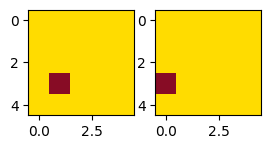

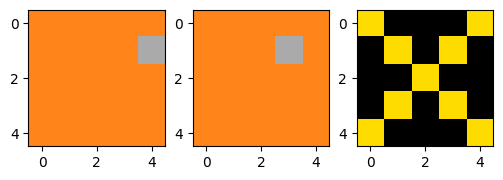

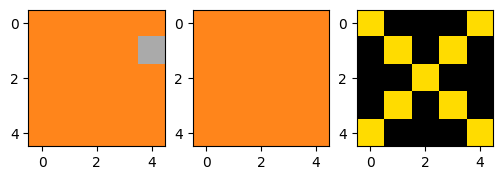

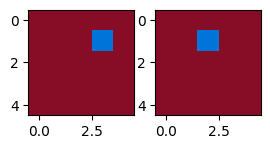

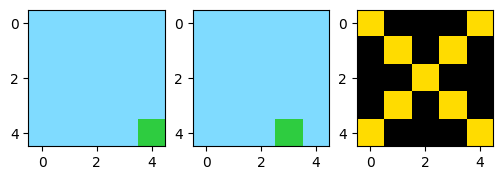

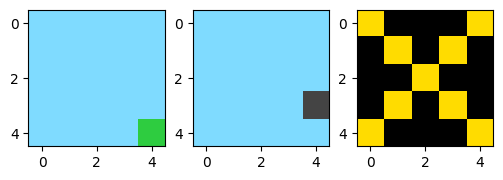

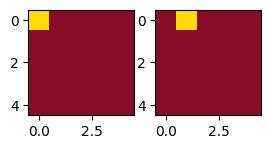

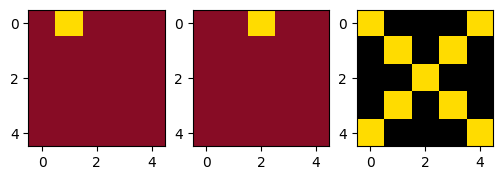

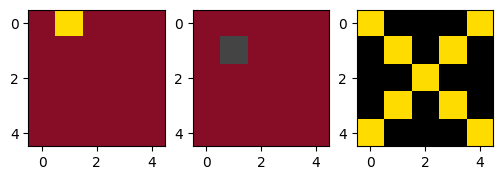

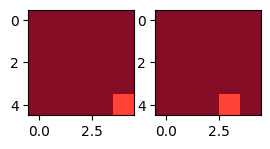

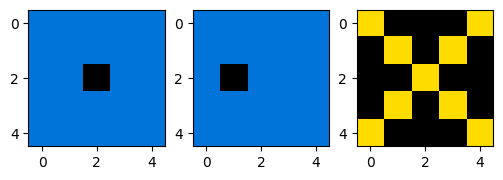

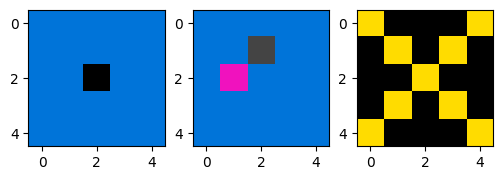

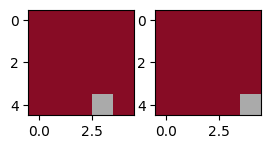

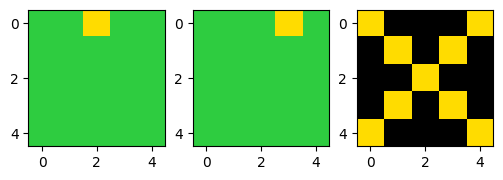

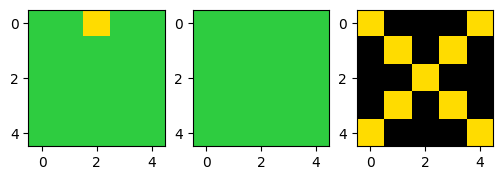

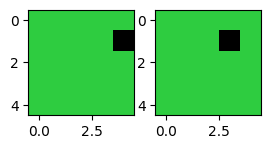

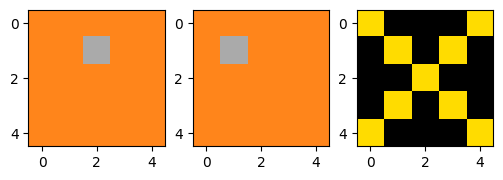

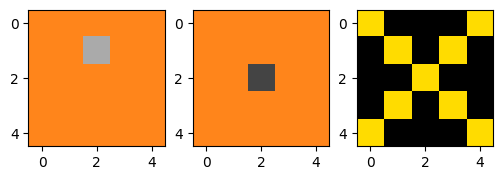

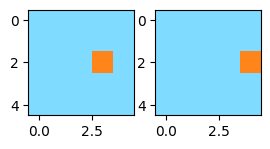

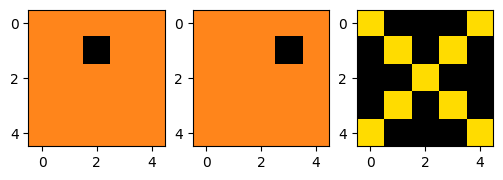

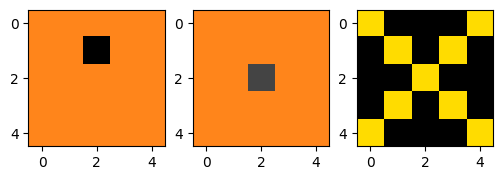

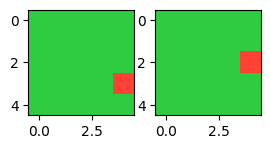

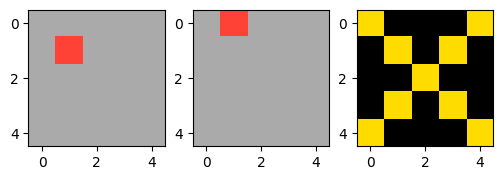

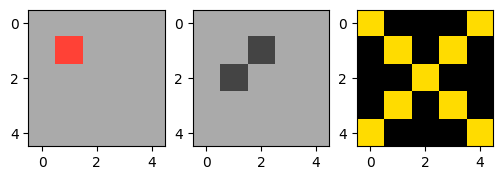

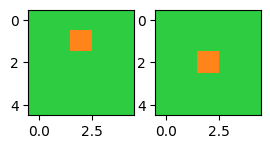

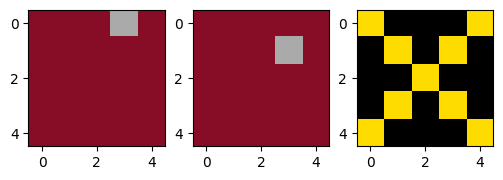

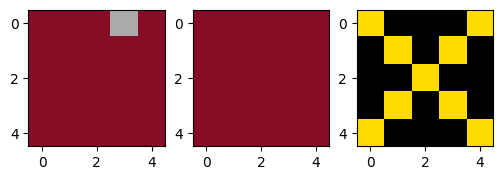

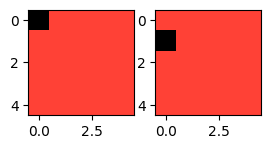

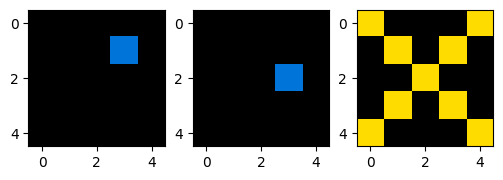

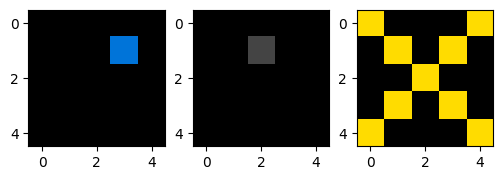

In [80]:
cases = [c+"_test_0" for c in crt.keys()]
inds = []
for c in cases:
    inds.append(next(i for i, s in enumerate(validatn_set.names) if s.endswith(c)))
solve_and_plot(transformer, validatn_set, inds)


## Plot Incorrect Train Tasks

11634
[1, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 18, 19, 22, 23, 24, 25, 26, 27, 30, 31, 32, 34, 35, 38, 39, 42, 43, 44, 46, 47, 48, 51, 52, 56, 59, 60, 63, 64, 70, 71, 72, 73, 74, 75, 77, 79, 80, 83, 84, 85, 86, 88, 89, 91, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 107, 108, 112, 115, 116, 119, 120, 121, 122, 123, 127, 128, 129, 131, 132, 133, 136, 137, 139, 143, 144, 147, 148, 151, 152, 155, 156, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 175, 176, 177, 180, 181, 182, 184, 188, 189, 190, 191, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 212, 213, 217, 218, 224, 225, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 252, 256, 257, 258, 260, 261, 262, 269, 272, 273, 277, 280, 281, 284, 285, 286, 289, 290, 293, 296, 297, 298, 300, 301, 302, 303, 305, 306, 308, 309, 310, 312, 313, 314, 317, 318, 319, 321, 322, 323, 325, 326, 330, 334, 336, 337, 341, 342, 343, 344, 345, 346, 347, 349, 350, 353, 

<ipython-input-66-b6384dd7e73c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (6, 9))


(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.010796081743595785, shape=(), dtype=float64)
Task index: 18093, Input: moveapixelxone-5x5-multicolor-d-c5280017e8_train_2|moveapixelxone-5x5-multicolor-d-c5280017e8_train_1, Target: moveapixelxone-5x5-multicolor-d-c5280017e8_train_2|moveapixelxone-5x5-multicolor-d-c5280017e8_train_1
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.004965271503091524, shape=(), dtype=float64)
Task index: 10136, Input: moveapixelxone-5x5-multicolor-u-26b7ee108a_train_1|moveapixelxone-5x5-multicolor-u-26b7ee108a_train_2, Target: moveapixelxone-5x5-multicolor-u-26b7ee108a_train_1|moveapixelxone-5x5-multicolor-u-26b7ee108a_train_2
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.013576125170686888, shape=(), dtype=float64)


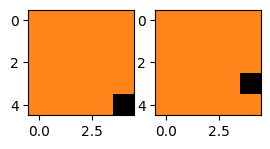

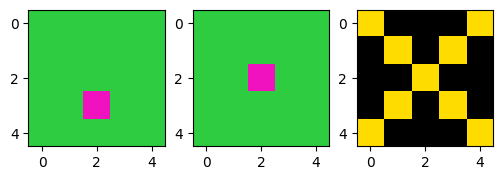

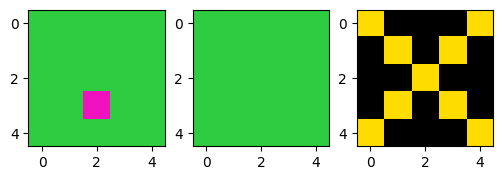

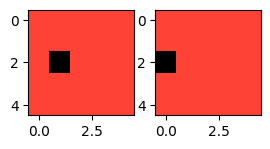

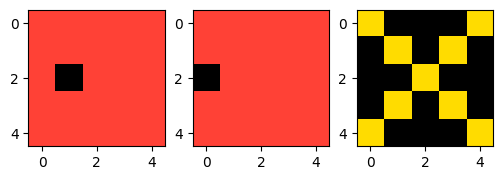

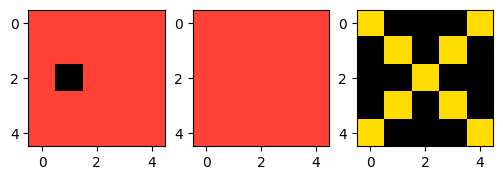

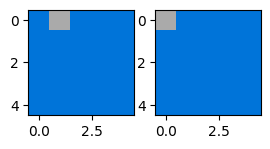

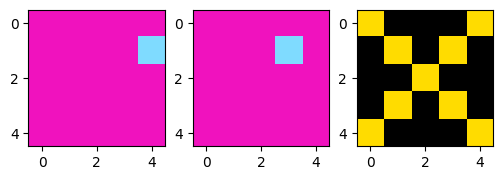

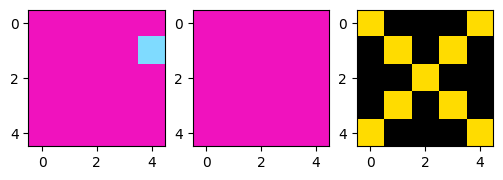

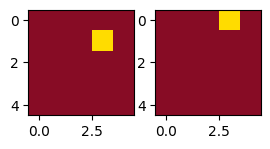

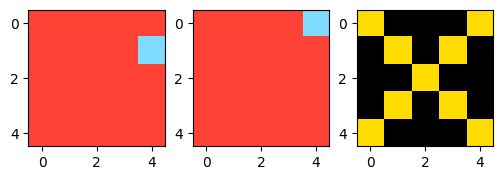

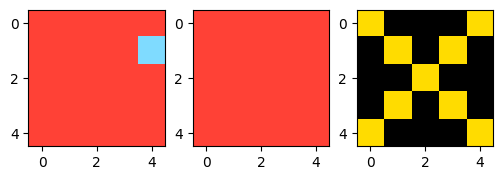

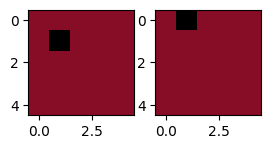

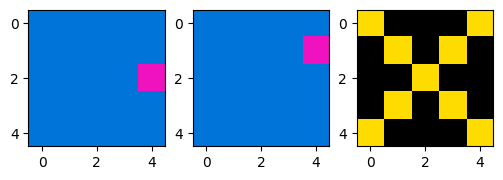

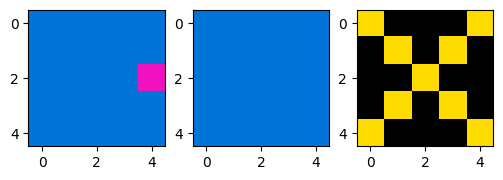

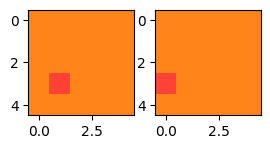

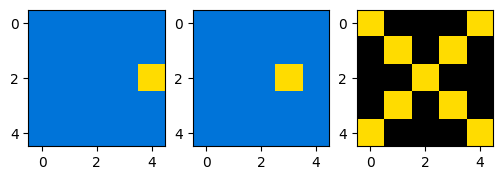

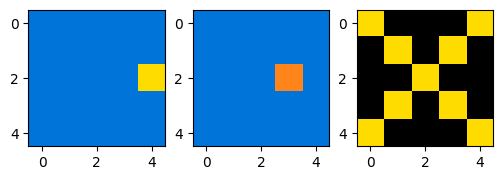

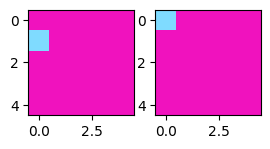

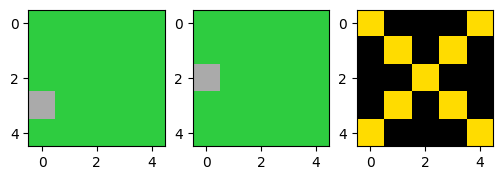

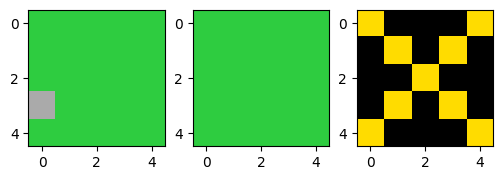

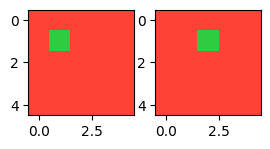

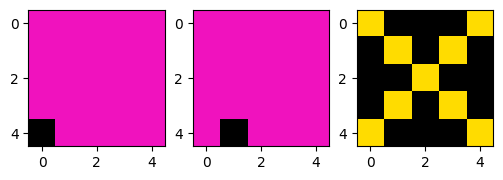

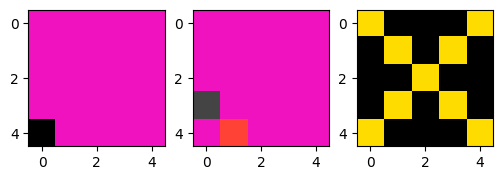

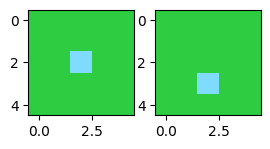

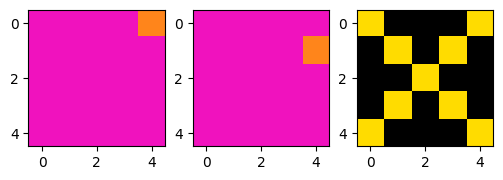

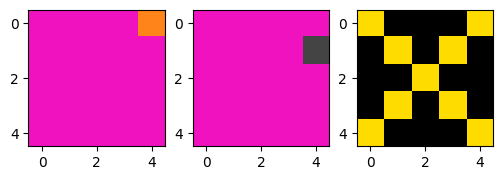

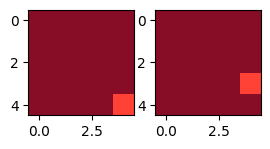

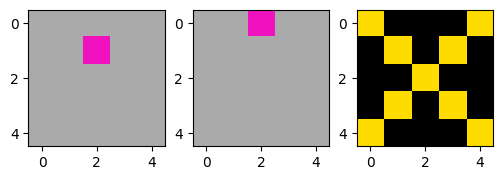

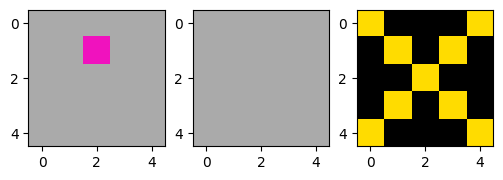

In [81]:
incorrect_idxs = [ x for x in range(len(training_set.names)) if x not in correct_idxs ]
print(len(incorrect_idxs))
print(incorrect_idxs)
if len(incorrect_idxs) > 0:
  if len(incorrect_idxs) > 10:
    subset=[ incorrect_idxs[np.random.randint(0, len(incorrect_idxs))] for i in range(10) ]
  else:
    subset=incorrect_idxs
  print(subset)
  solve_and_plot(transformer, training_set, subset)

## Random Pick from Training Set

Task index: 17448, Input: moveapixelxone-5x5-multicolor-d-9fa0f4a727_train_2|moveapixelxone-5x5-multicolor-d-9fa0f4a727_train_1, Target: moveapixelxone-5x5-multicolor-d-9fa0f4a727_train_2|moveapixelxone-5x5-multicolor-d-9fa0f4a727_train_1
(3, 5, 5, 3) (2, 5, 5, 3)
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0019360659454096272, shape=(), dtype=float64)


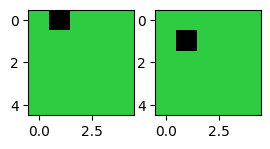

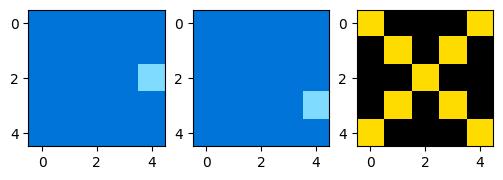

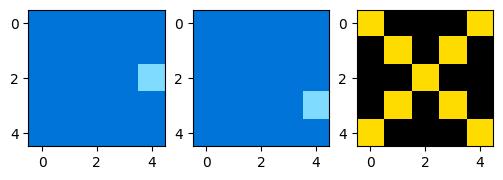

In [82]:
solve_and_plot(transformer, training_set)